In [72]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

In [73]:
try: 
    import optuna
except:
    !pip install optuna
    import optuna

In [74]:
try:
    from CustomPipeline import *
except:
    import sys
    sys.path.insert(0,'/content/sample_data')
    from CustomPipeline import *
    print("ok")

In [75]:
test_ensemble = pd.read_csv("./en_test_ensemble.csv", delimiter=",", sep='.')
test = pd.read_csv("./en_test_witout_target.csv", delimiter=",", sep='.', index_col='id')
train_ensemble = pd.read_csv("./en_train_ensemble.csv", delimiter=",", sep='.')

In [76]:
df = pd.read_csv("./ensemble_with_clusters.csv", delimiter=",", sep='.')

# Feature engeneering with k-means

In [77]:
df.head(3)

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,label,k_means_,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,Norm,811.794579,802.49600,test,0,0,0,0
1,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,Norm,841.286617,838.92790,test,8,0,0,0
2,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,Norm,837.758268,841.12854,test,4,0,0,0


In [78]:
df.iloc[:, 25:]

,0,1,label,k_means_,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
0,811.794579,802.49600,test,0,0,0,0
1,841.286617,838.92790,test,8,0,0,0
2,837.758268,841.12854,test,4,0,0,0
3,853.769654,847.46990,test,4,0,0,0
4,819.820749,811.22650,test,8,0,0,0
...,...,...,...,...,...,...,...
283995,869.400623,867.26910,test_ensemble,6,0,0,0
283996,810.539736,808.34860,test_ensemble,6,0,0,0
283997,808.015706,809.41300,test_ensemble,8,0,0,0
283998,785.915281,782.50354,test_ensemble,3,0,0,0


In [79]:
# cast int to obj
df.iloc[:, 28:] = df.iloc[:, 28:].astype('object')

In [80]:
df = df.iloc[:, 25:].copy()

In [81]:
df.head(2)

,0,1,label,k_means_,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
0,811.794579,802.4960,test,0,0,0,0
1,841.286617,838.9279,test,8,0,0,0


In [82]:
test_new = df[df['label'] == 'test'].drop('label', axis=1)
train_ensemble_new = df[df['label'] == 'train_ensemble'].drop('label', axis=1)
test_ensemble_new = df[df['label'] == 'test_ensemble'].drop('label', axis=1)

In [98]:
X = train_ensemble_new
y = train_ensemble['target']

num_train = X.select_dtypes([int, float])
cat_train = X.select_dtypes(object)

num = list(num_train)
cat = list(cat_train)
cat_features = [X.columns.get_loc(i) for i in cat]

rmse = make_scorer(mean_squared_error, squared=False)

pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler()),  
    ('normal', PowerTransformer()), 
    ('bins', KBinsDiscretizer(n_bins = 50))
])
pipeline_cat = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore')),
])
preprocessor = ColumnTransformer(n_jobs=-1,
    transformers=[
        ('num', pipeline_num, num),
        ('cat', pipeline_cat, cat),
        ], remainder="passthrough")


preprocessor.fit(df.drop('label', axis=1))
transform = preprocessor.transform(X)
X_test_ensemble = preprocessor.transform(test_ensemble_new)
X_test = preprocessor.transform(test_new)


In [103]:
def objective(trial):
    
    param_model = {
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'random_state':trial.suggest_categorical("random_state", [0, 1, 42]),
    }
    
    pipeline_ridge = Pipeline(steps=[ 
                                     ('model', linear_model.Lasso(**param_model)),
                                     ])

    rmse_mean_cv = cross_val_score(pipeline_ridge, transform, y, cv=5, scoring=rmse)
    print(rmse_mean_cv)

    return rmse_mean_cv.mean()

In [101]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)
# 72.05929420329886.
# 72.05702112640415.

[I 2021-08-31 17:22:02,464] A new study created in memory with name: no-name-8a43643a-826b-4742-a627-20d1c458be45
[W 2021-08-31 17:22:02,467] Trial 0 failed because of the following error: NameError("name 'cv' is not defined")
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\optuna\_optimize.py", line 211, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-100-16ee3baa2d97>", line 47, in objective
    rmse = cv(train_pool, param, fold_count=5, plot=False, logging_level="Silent")
NameError: name 'cv' is not defined


NameError: name 'cv' is not defined

In [86]:
best_params = study.best_trial.params
best_params 

{'alpha': 0.007912748297307967, 'random_state': 1}

# check bias clusters

In [87]:
model = linear_model.Lasso(**best_params)
model.fit(transform, y)

Lasso(alpha=0.007912748297307967, random_state=1)

In [88]:
model.coef_

array([-1.84122216e+01, -1.42219506e+01, -1.21837663e+01, -8.06999233e+00,
       -1.10418955e+01, -1.09331571e+01, -1.15959777e+01, -3.68935114e+00,
       -7.34221855e+00, -7.83512248e+00, -4.17636179e+00, -3.68072609e+00,
       -5.39889387e+00, -2.77711900e+00, -4.90479954e+00, -2.64345260e+00,
       -2.34534570e+00, -4.05780567e+00, -0.00000000e+00,  4.39244832e-01,
       -4.70920092e+00,  1.08239462e+00,  0.00000000e+00, -2.87472220e-01,
        1.73850515e-01, -3.07391557e+00,  1.49043760e+00, -1.72243873e+00,
       -0.00000000e+00,  2.26784221e+00,  3.60075535e+00,  5.04302123e-01,
        6.71512003e-01, -2.60638002e+00,  3.86175467e+00,  5.99604545e+00,
        3.52922980e+00,  2.04904521e+00,  2.22385438e+00,  5.54754754e+00,
        6.07366350e+00,  4.99212413e+00,  2.38507171e+00,  5.85534782e+00,
        6.57749915e+00,  1.22224653e+01,  8.94607628e+00,  4.61994443e+00,
        7.19914165e+00,  9.38968497e+00, -4.08971728e+01, -3.68101478e+01,
       -2.87302613e+01, -

In [89]:
X.head(2)

,0,1,k_means_,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
200000,822.393348,840.8753,8,0,0,1
200001,821.181948,802.0976,1,0,0,0


In [90]:
pred = model.predict(transform)
train_ensemble['pred_lasso'] = pred

In [91]:
pred = model.predict(X_test_ensemble)
print(mean_squared_error(test_ensemble["target"], pred, squared=False))

71.84399968357236


In [92]:
pred = model.predict(X_test)
test['target'] = pred / 100

# Residuals

In [93]:
train_ensemble['residuals'] = train_ensemble['target'] - train_ensemble['0']
train_ensemble['label'] = train_ensemble.residuals.apply(lambda x: 1 if x > -180 else 0) 

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0'>

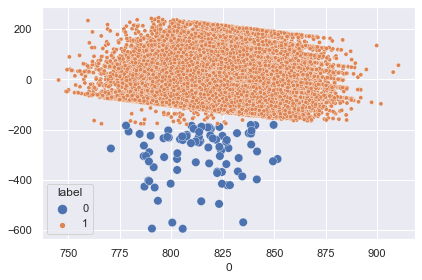

In [94]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
residuals = train_ensemble['target'] - train_ensemble['0']
sns.scatterplot(train_ensemble['0'], residuals, hue = train_ensemble['label'], size=train_ensemble['label'])

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='pred_lasso'>

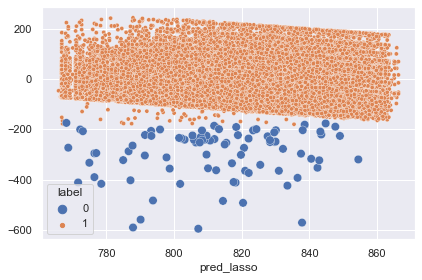

In [95]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
residuals = train_ensemble['target'] - train_ensemble['pred_lasso']
sns.scatterplot(train_ensemble['pred_lasso'], residuals, hue = train_ensemble['label'], size=train_ensemble['label'])

# save predict

In [96]:
test.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,Norm,811.794579,802.49600,8.074918
5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,Norm,841.286617,838.92790,8.360537
15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,Norm,837.758268,841.12854,8.412072
16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,Norm,853.769654,847.46990,8.546619
17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,Norm,819.820749,811.22650,8.086334


In [97]:
test[['target']].to_csv('./ensemble_for_submit_with_clusters.csv', index=True)